# MERLIN based Anomaly Detection for ECG Seizure Detection

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Add the Information/Merlin directory to path to import MERLIN
sys.path.append(os.path.join('..', 'Information', 'Merlin'))

try:
    from _merlin import MERLIN
    print("✓ MERLIN successfully imported")
except ImportError:
    print("❌ MERLIN import failed.")

✓ MERLIN successfully imported


In [20]:
def run_merlin_on_sample(sample: np.array, min_length: int = 5, max_length: int = 20) -> np.array:
    """Run MERLIN anomaly detection on a time series sample"""
    detector = MERLIN(min_length=min_length, max_length=max_length)
    return detector.fit_predict(sample)

In [21]:
def get_anomaly_indices_from_merlin(anomalies: np.array) -> np.array:
    """Get indices of detected anomalies"""
    return np.where(anomalies)[0]

In [22]:
def plot_merlin_results(sample: np.ndarray, anomalies: np.ndarray) -> plt.Figure:
    """Plot time series with MERLIN anomaly detection results"""
    fig, ax = plt.subplots(2, 1, figsize=(12, 6))

    # Plot original time series
    ax[0].plot(sample, 'b-', linewidth=1, label='Time Series')
    
    # Highlight anomalies
    anomaly_indices = get_anomaly_indices_from_merlin(anomalies)
    if len(anomaly_indices) > 0:
        ax[0].scatter(anomaly_indices, sample[anomaly_indices], 
                     color='red', s=50, alpha=0.8, label='MERLIN Anomalies')
    
    ax[0].set_title("Time Series with MERLIN Anomaly Detection")
    ax[0].set_xlabel("Time Index")
    ax[0].set_ylabel("Value")
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)

    # Plot anomaly mask
    ax[1].plot(anomalies.astype(int), 'r-', linewidth=2)
    ax[1].fill_between(range(len(anomalies)), anomalies.astype(int), alpha=0.3, color='red')
    ax[1].set_title(f"Anomaly Detection Results (Found {np.sum(anomalies)} anomalies)")
    ax[1].set_xlabel("Time Index")
    ax[1].set_ylabel("Anomaly (0/1)")
    ax[1].set_ylim(-0.1, 1.1)
    ax[1].grid(True, alpha=0.3)

    fig.text(0.01, 0.01, "MERLIN: Discord discovery for anomaly detection", 
             fontsize=8, color="gray")
    fig.tight_layout()
    plt.show()
    
    return fig

## Demo 1: Simple anomaly in regular pattern

Detected anomalies at indices: [4 5]


c:\Users\Reintjes\Documents\aD\UoC\Semester2\ASIM\Projekt\ecg-seizure-detection\venv_win\Lib\site-packages\aeon\anomaly_detection\base.py:208: UserWarning: There is region close to constant that will cause the results to be unstable. It is suggested to delete the constant region or try again with a longer min_length.
  return self._predict(X)


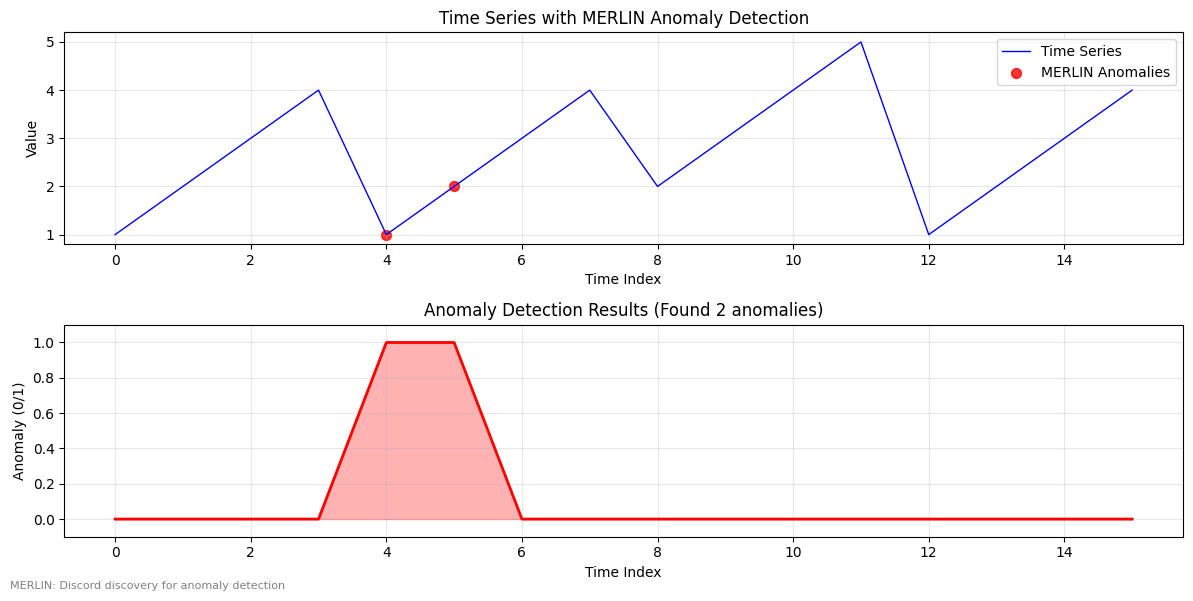

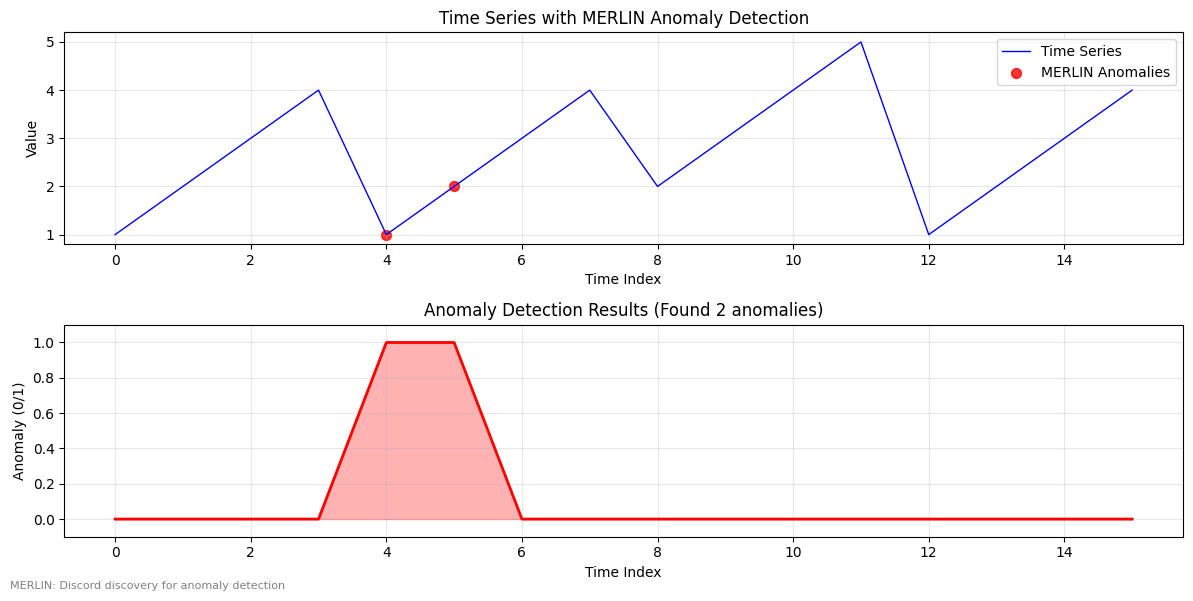

In [23]:
# Create a simple time series with one clear anomaly
timeseries = np.array([1, 2, 3, 4, 1, 2, 3, 4, 2, 3, 4, 5, 1, 2, 3, 4], dtype=np.float64)

# Run MERLIN
anomalies = run_merlin_on_sample(timeseries, min_length=4, max_length=5)
print(f"Detected anomalies at indices: {get_anomaly_indices_from_merlin(anomalies)}")

# Plot results
plot_merlin_results(timeseries, anomalies)

## Demo 2: Multiple anomalies in noisy data

Time series length: 50
Injected anomalies at indices: [15, 30, 40]
MERLIN detected anomalies at indices: [16 24 26 28 29]


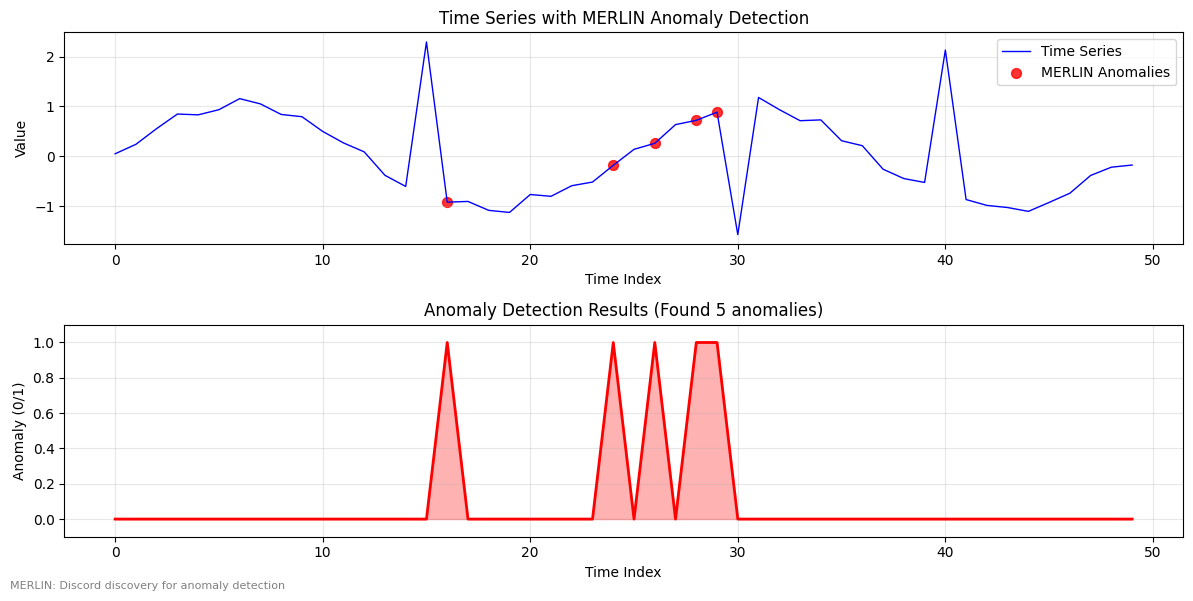

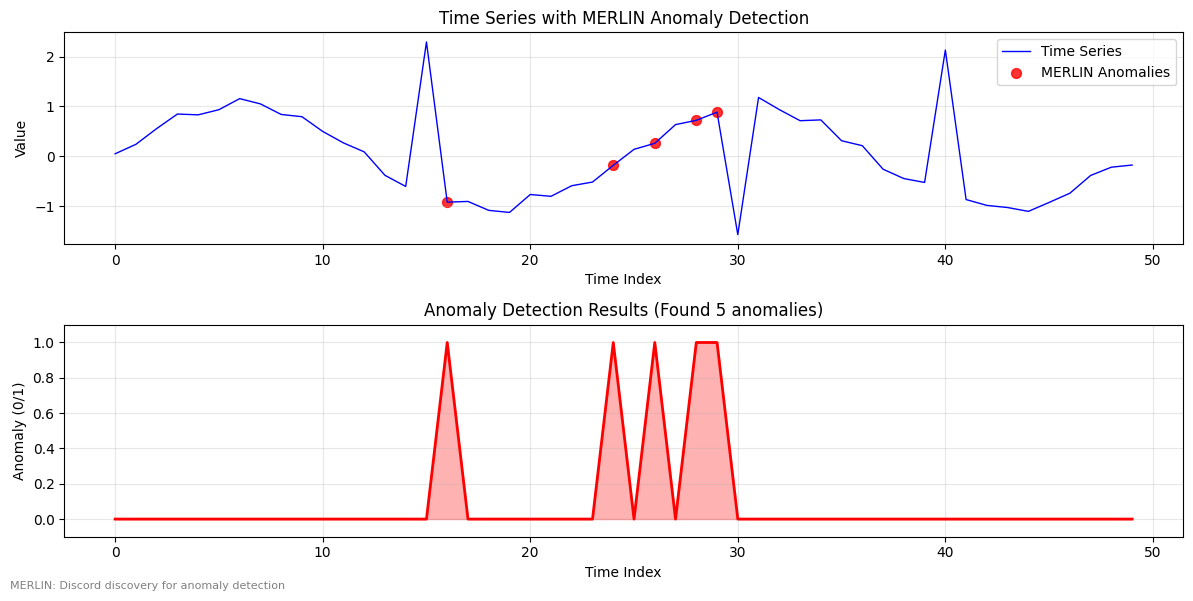

In [24]:
# Create a more complex time series with multiple anomalies
np.random.seed(42)
baseline = np.sin(np.linspace(0, 4*np.pi, 50)) + 0.1 * np.random.randn(50)

# Add some anomalies
timeseries = baseline.copy()
timeseries[15] += 3  # Positive anomaly
timeseries[30] -= 2.5  # Negative anomaly
timeseries[40] += 2.8  # Another positive anomaly

print(f"Time series length: {len(timeseries)}")
print(f"Injected anomalies at indices: [15, 30, 40]")

# Run MERLIN
anomalies = run_merlin_on_sample(timeseries, min_length=5, max_length=15)
detected_indices = get_anomaly_indices_from_merlin(anomalies)
print(f"MERLIN detected anomalies at indices: {detected_indices}")

# Plot results
plot_merlin_results(timeseries, anomalies)

## Demo 3: ECG-like signal with simulated seizure

ECG-like signal length: 1000 samples
Sampling rate: 100 Hz
Simulated seizure from index 400 to 600 (4.0s - 6.0s)
MERLIN detected 177 anomalies
Anomalies in seizure region (400-600): 62


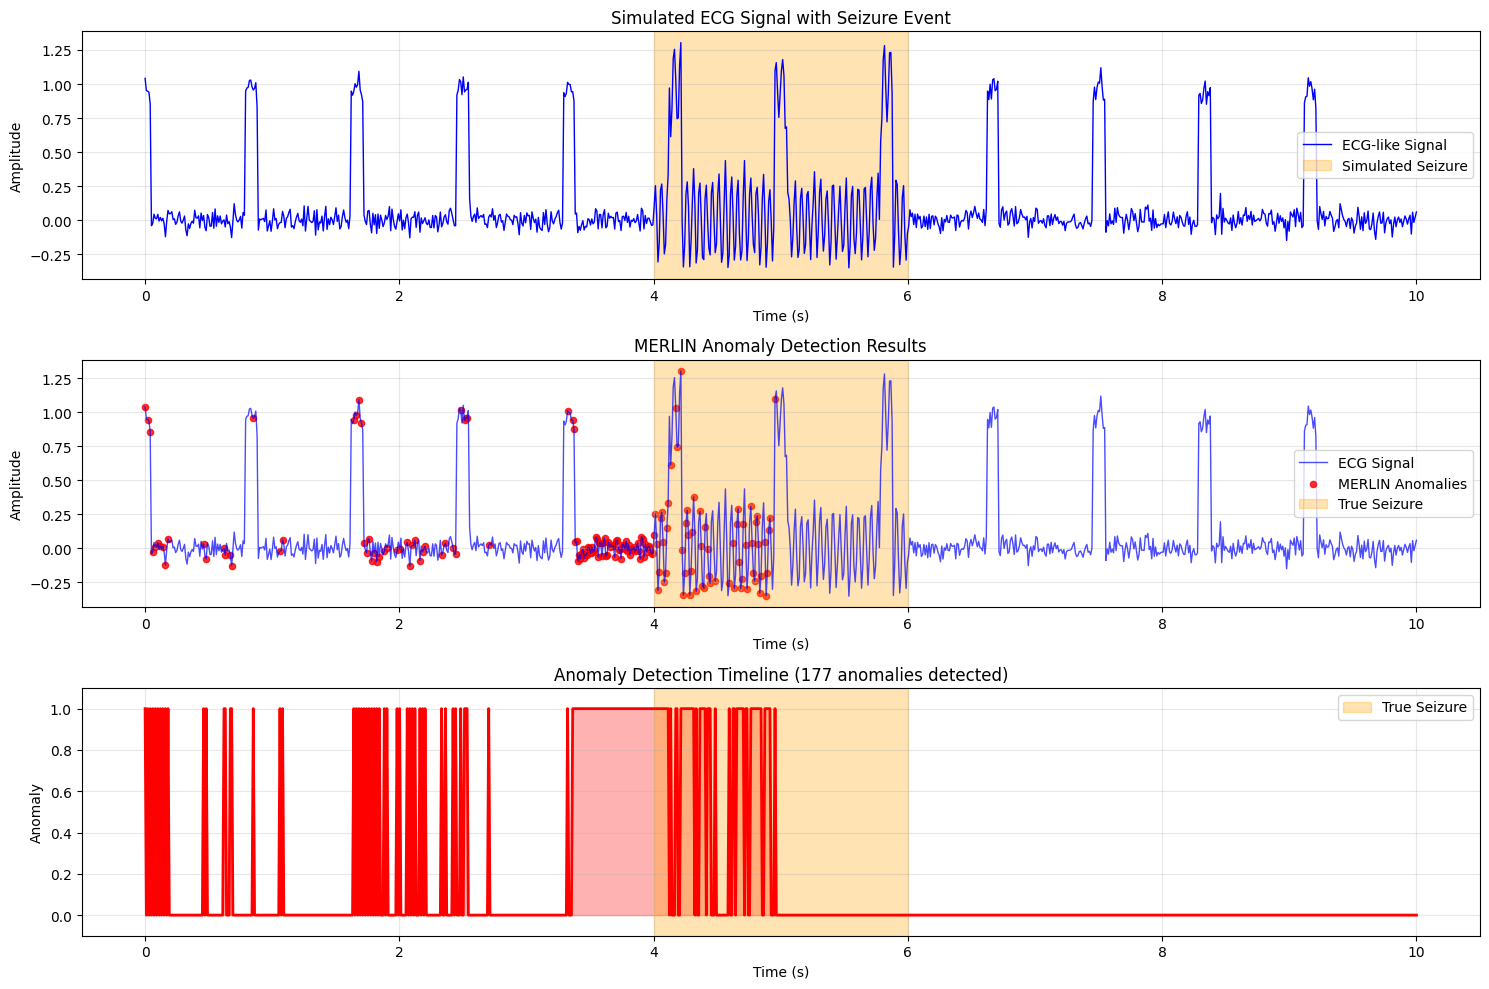


Detection Performance:
  Seizure detected: Yes
  Detection rate in seizure region: 31.00%
  False alarms outside seizure: 115
  Total anomalies detected: 177


In [28]:
# Create an ECG-like signal
t = np.linspace(0, 10, 1000)  # 10 seconds, 100 Hz sampling
heart_rate = 72  # BPM
heart_period = 60 / heart_rate

# Generate ECG-like signal with QRS complexes
ecg_signal = np.zeros_like(t)
for beat_time in np.arange(0, 10, heart_period):
    # Add QRS complex (simplified)
    qrs_indices = np.where(np.abs(t - beat_time) < 0.05)[0]
    for idx in qrs_indices:
        ecg_signal[idx] += np.exp(-50 * (t[idx] - beat_time)**2)

# Add some noise
ecg_signal += 0.05 * np.random.randn(len(t))

# Simulate a seizure event (irregular high-frequency activity)
seizure_start = 400  # Around 4 seconds
seizure_end = 600    # Around 6 seconds
seizure_activity = 0.3 * np.sin(2 * np.pi * 20 * t[seizure_start:seizure_end])  # 20 Hz activity
ecg_signal[seizure_start:seizure_end] += seizure_activity

print(f"ECG-like signal length: {len(ecg_signal)} samples")
print(f"Sampling rate: {len(ecg_signal)/10:.0f} Hz")
print(f"Simulated seizure from index {seizure_start} to {seizure_end} ({seizure_start/100:.1f}s - {seizure_end/100:.1f}s)")

# Run MERLIN
anomalies = run_merlin_on_sample(ecg_signal, min_length=200, max_length=500)
detected_indices = get_anomaly_indices_from_merlin(anomalies)
print(f"MERLIN detected {len(detected_indices)} anomalies")
print(f"Anomalies in seizure region ({seizure_start}-{seizure_end}): {np.sum(anomalies[seizure_start:seizure_end])}")

# Plot results
fig, ax = plt.subplots(3, 1, figsize=(15, 10))

# Plot original ECG-like signal
time_seconds = t
ax[0].plot(time_seconds, ecg_signal, 'b-', linewidth=1, label='ECG-like Signal')
ax[0].axvspan(seizure_start/100, seizure_end/100, alpha=0.3, color='orange', label='Simulated Seizure')
ax[0].set_title("Simulated ECG Signal with Seizure Event")
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Amplitude")
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# Plot signal with anomalies highlighted
ax[1].plot(time_seconds, ecg_signal, 'b-', linewidth=1, alpha=0.7, label='ECG Signal')
if len(detected_indices) > 0:
    ax[1].scatter(time_seconds[detected_indices], ecg_signal[detected_indices], 
                 color='red', s=20, alpha=0.8, label='MERLIN Anomalies')
ax[1].axvspan(seizure_start/100, seizure_end/100, alpha=0.3, color='orange', label='True Seizure')
ax[1].set_title("MERLIN Anomaly Detection Results")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Amplitude")
ax[1].legend()
ax[1].grid(True, alpha=0.3)

# Plot anomaly detection mask
ax[2].plot(time_seconds, anomalies.astype(float), 'r-', linewidth=2)
ax[2].fill_between(time_seconds, anomalies.astype(float), alpha=0.3, color='red')
ax[2].axvspan(seizure_start/100, seizure_end/100, alpha=0.3, color='orange', label='True Seizure')
ax[2].set_title(f"Anomaly Detection Timeline ({np.sum(anomalies)} anomalies detected)")
ax[2].set_xlabel("Time (s)")
ax[2].set_ylabel("Anomaly")
ax[2].set_ylim(-0.1, 1.1)
ax[2].legend()
ax[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate detection performance
true_seizure_mask = np.zeros_like(anomalies)
true_seizure_mask[seizure_start:seizure_end] = True

# Simple overlap-based evaluation
seizure_detected = np.any(anomalies[seizure_start:seizure_end])
detection_rate_in_seizure = np.sum(anomalies[seizure_start:seizure_end]) / (seizure_end - seizure_start)
false_alarms_outside_seizure = np.sum(anomalies) - np.sum(anomalies[seizure_start:seizure_end])

print(f"\nDetection Performance:")
print(f"  Seizure detected: {'Yes' if seizure_detected else 'No'}")
print(f"  Detection rate in seizure region: {detection_rate_in_seizure:.2%}")
print(f"  False alarms outside seizure: {false_alarms_outside_seizure}")
print(f"  Total anomalies detected: {np.sum(anomalies)}")

## Demo 4: Parameter comparison


Testing Short windows (min_length=100, max_length=200)


c:\Users\Reintjes\Documents\aD\UoC\Semester2\ASIM\Projekt\ecg-seizure-detection\venv_win\Lib\site-packages\aeon\anomaly_detection\base.py:208: UserWarning: There is region close to constant that will cause the results to be unstable. It is suggested to delete the constant region or try again with a longer min_length.
  return self._predict(X)


  Anomalies detected: 57
  Seizure detected: Yes
  Detection rate in seizure: 13.50%

Testing Medium windows (min_length=200, max_length=350)
  Anomalies detected: 95
  Seizure detected: Yes
  Detection rate in seizure: 13.00%

Testing Long windows (min_length=300, max_length=500)
  Anomalies detected: 140
  Seizure detected: Yes
  Detection rate in seizure: 21.50%


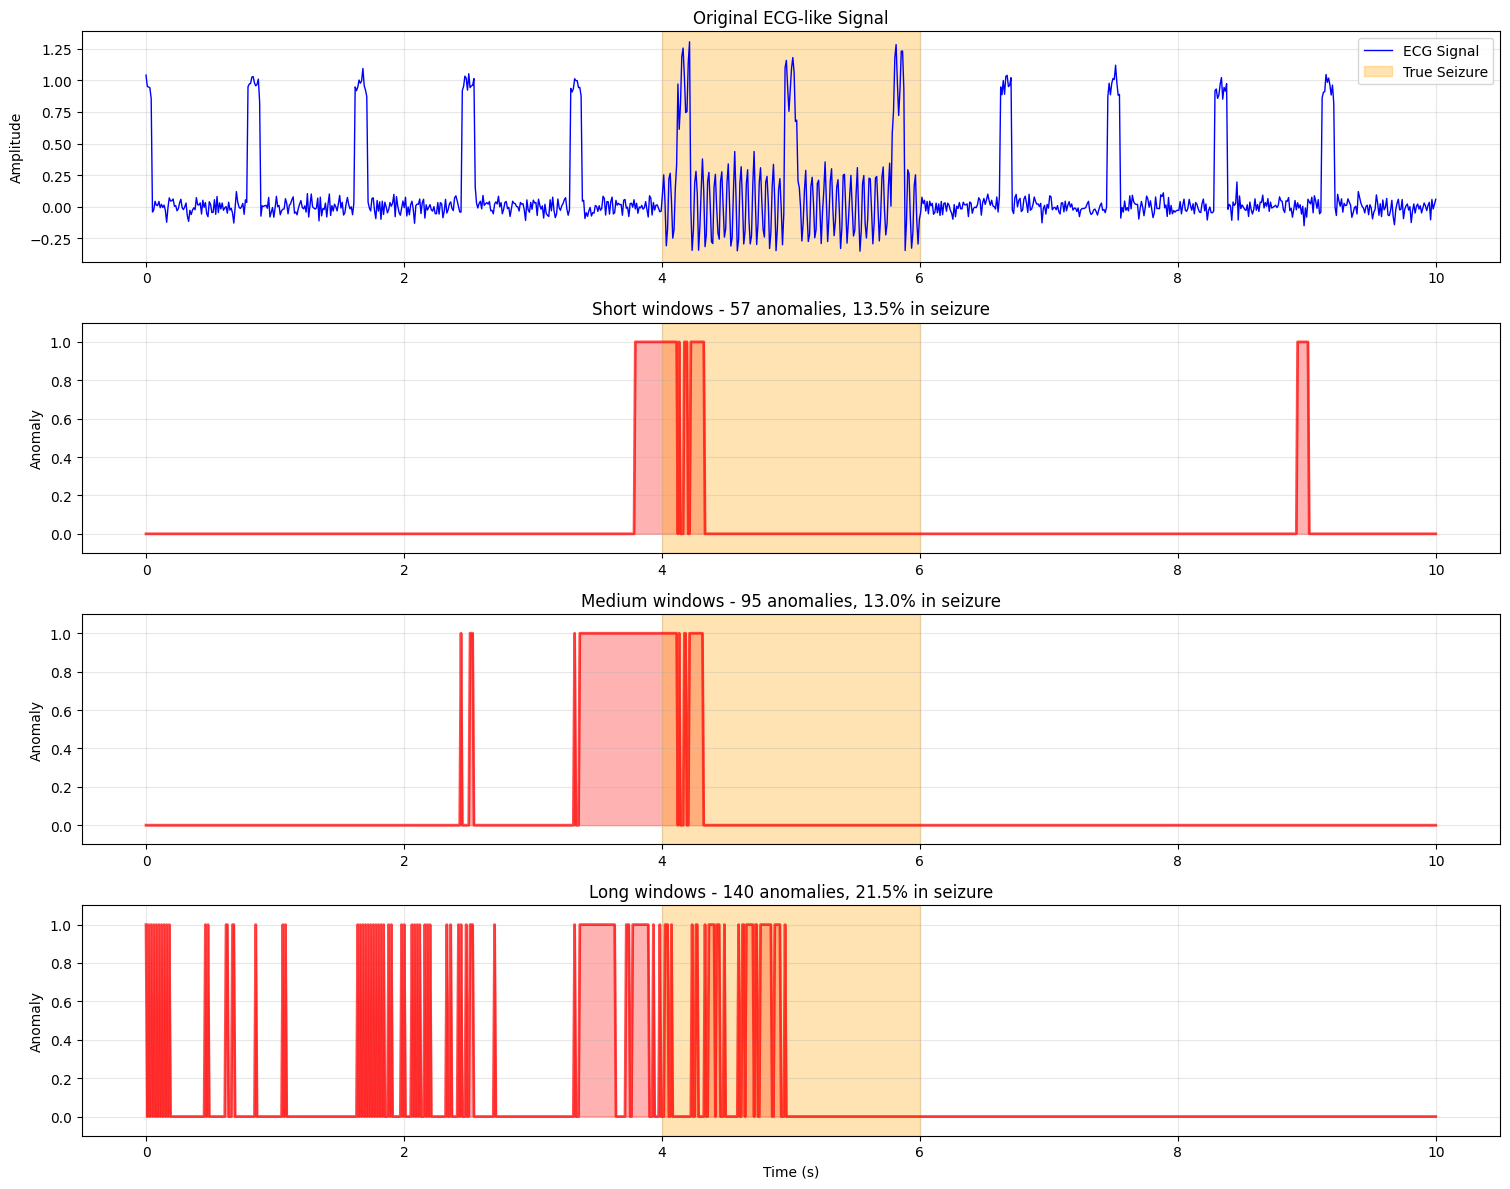


PARAMETER COMPARISON SUMMARY
Configuration   | Total  | Seizure  | Rate     | FalseAlarms
                | Anom.  | Detect.  | in Seiz. | Outside    
----------------------------------------------------------------------
Short windows   | 57     | Yes      | 13.5%    | 30         
Medium windows  | 95     | Yes      | 13.0%    | 69         
Long windows    | 140    | Yes      | 21.5%    | 97         

Best configuration for seizure detection: Long windows (21.5% detection rate)


In [29]:
# Compare different MERLIN parameter settings
parameter_configs = [
    {"name": "Short windows", "min_length": 100, "max_length": 200},
    {"name": "Medium windows", "min_length": 200, "max_length": 350},
    {"name": "Long windows", "min_length": 300, "max_length": 500}
]

# Use the ECG-like signal from Demo 3
test_signal = ecg_signal.copy()

fig, axes = plt.subplots(len(parameter_configs) + 1, 1, figsize=(15, 3 * (len(parameter_configs) + 1)))

# Plot original signal
axes[0].plot(time_seconds, test_signal, 'b-', linewidth=1, label='ECG Signal')
axes[0].axvspan(seizure_start/100, seizure_end/100, alpha=0.3, color='orange', label='True Seizure')
axes[0].set_title("Original ECG-like Signal")
axes[0].set_ylabel("Amplitude")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test each configuration
results_summary = []

for i, config in enumerate(parameter_configs):
    print(f"\nTesting {config['name']} (min_length={config['min_length']}, max_length={config['max_length']})")
    
    # Run MERLIN with current config
    anomalies = run_merlin_on_sample(test_signal, 
                                   min_length=config['min_length'], 
                                   max_length=config['max_length'])
    
    detected_indices = get_anomaly_indices_from_merlin(anomalies)
    
    # Calculate metrics
    seizure_detected = np.any(anomalies[seizure_start:seizure_end])
    detection_rate_in_seizure = np.sum(anomalies[seizure_start:seizure_end]) / (seizure_end - seizure_start)
    total_anomalies = np.sum(anomalies)
    false_alarms = total_anomalies - np.sum(anomalies[seizure_start:seizure_end])
    
    results_summary.append({
        'config': config['name'],
        'seizure_detected': seizure_detected,
        'detection_rate': detection_rate_in_seizure,
        'total_anomalies': total_anomalies,
        'false_alarms': false_alarms
    })
    
    print(f"  Anomalies detected: {total_anomalies}")
    print(f"  Seizure detected: {'Yes' if seizure_detected else 'No'}")
    print(f"  Detection rate in seizure: {detection_rate_in_seizure:.2%}")
    
    # Plot anomaly timeline
    axes[i+1].plot(time_seconds, anomalies.astype(float), 'r-', linewidth=2, alpha=0.7)
    axes[i+1].fill_between(time_seconds, anomalies.astype(float), alpha=0.3, color='red')
    axes[i+1].axvspan(seizure_start/100, seizure_end/100, alpha=0.3, color='orange')
    axes[i+1].set_title(f"{config['name']} - {total_anomalies} anomalies, {detection_rate_in_seizure:.1%} in seizure")
    axes[i+1].set_ylabel("Anomaly")
    axes[i+1].set_ylim(-0.1, 1.1)
    axes[i+1].grid(True, alpha=0.3)

axes[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()

# Summary table
print(f"\n{'='*70}")
print(f"PARAMETER COMPARISON SUMMARY")
print(f"{'='*70}")
print(f"{'Configuration':<15} | {'Total':<6} | {'Seizure':<8} | {'Rate':<8} | {'FalseAlarms':<11}")
print(f"{'':15} | {'Anom.':<6} | {'Detect.':<8} | {'in Seiz.':<8} | {'Outside':<11}")
print("-" * 70)

for result in results_summary:
    seizure_status = "Yes" if result['seizure_detected'] else "No"
    print(f"{result['config']:<15} | {result['total_anomalies']:<6} | {seizure_status:<8} | "
          f"{result['detection_rate']:<8.1%} | {result['false_alarms']:<11}")

print(f"\nBest configuration for seizure detection: ", end="")
best_config = max(results_summary, key=lambda x: x['detection_rate'] if x['seizure_detected'] else 0)
print(f"{best_config['config']} ({best_config['detection_rate']:.1%} detection rate)")

## Summary

This notebook demonstrates the basic functionality of MERLIN (Parameter-Free Discovery of Arbitrary Length Anomalies) for anomaly detection:

1. **Simple Anomaly Detection**: MERLIN can detect obvious outliers in regular patterns
2. **Multiple Anomalies**: Works with multiple anomalies in noisy data
3. **ECG-like Signals**: Can be applied to ECG-like signals to detect seizure-like events
4. **Parameter Tuning**: Different window lengths affect sensitivity and specificity

